# Chapter 8. Multiple Agents

$$ % Latex macros
\newcommand{\mat}[1]{\begin{pmatrix} #1 \end{pmatrix}}
\newcommand{\p}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\b}[1]{\boldsymbol{#1}}
\newcommand{\c}[1]{\mathcal{#1}}
$$

## Contents

* Evolutionary algorithms


* Game theory


* Evolutionary game theory



## Evolutionary Algorithms

Our brain is a product of the long history of evolution.
In order to understand the present organization and functioning of our brain, it is mandatory to look back into its evolutionary history.

Learning and evolution are complementary mechanisms for adaptation in different time and spatial scales.
Learning happens within the lifetime of each single agent, within days to seconds.
Evolution occurs across multiple generations of a group of agents constituting a species or a colony.

The mechanisms of learning in the brain, such as the network architecture, dynamics of neurons, and synaptic plasticity rules, are shaped by evolution to suite the features of the environment and the agents' sensory-motor sytems.
Learning can also affect the course of evolution, by providing a wider variety of phenotypes through interaction with the physical and social environments.

*Evolutionary algorithms* are a class of adaptation/optimization algorithms that mimick the process of biological evolution. The major components are:
* diversity in population
* selection by fitness
* variation by mutation/crossover

Compared to other optimization methods like Newton's method or gradient descent, their major features are
* global optimization
* little assumption on the objective function
* no gradient computation

## Variants of evolutionary algorithms

* Genetic algorithm (GA) 	(Holland 1976)
    * binary coding


* Evolutionary strategy		(Rechenberg & Schwefel 1965)
    * real numbers


* Evolutionary programming	(Fogel 1966)
    * genotype is a finite state machine


* Genetic programming (GP)	(Koza 1992)
    * phenotype is a program

### Genotype/phenotype coding

* Binary coding: $b_N,...,b_1$

$$ x = \sum_{i=1}^N b_n 2^{n–1} $$
Some flip of a bit can cause a big jump.

* Real numbers: $(x_1,...,x_N)$

* Genotype to phenotype mapping
    * input to a fitness function
    * parameters of a controller for behavior

### Selection

* Roulett wheel selection (RWS):
The selection probability $p_i$ for an individual of fitness $f_i$ is given by

$$ p_i = \frac{f_i}{\sum_{i=1}^P f_i} $$
where $P$ is the population size.
All $f_i$ have to be non-negative.

* Selection by ranking:

$$ p_i \propto P - rank_i $$

* Tournament selection:
Keep winners of subsets made of $k$ individuals

### Mutation

* Binary coding:
random filp of each bit

* Real coding:
add random noise,
e.g. Gaussian: $x’ = x + \c{N}(0,\sigma^2)$

### Crossover

* Binary coding:
splicing of bit sequences

* Blend crossover:

$$ x’ \in [x_1–\alpha(x_2–x_1), x_2+\alpha(x_2–x_1)] $$

* Sampling from parents’ distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting

In [6]:
class EvoAlg:
    """A basic class of evolutionary algorithms"""

    def __init__(self, fitfun, genes, amut=0.1, pcross=0.1):
        """Create a new population
        genes: (P,C) array of int or float
        sigma: mutation size"""
        self.fitfun = fitfun   # fitness function
        self.genes = np.array(genes)  # initial genotypes
        self.P = self.genes.shape[0]  # population size
        self.C = self.genes.shape[1]  # genetic code length
        self.amut = amut  # mutation amplitude
        self.pcross = pcross  # crossover probability
        self.fits = np.zeros(self.P)  # individual fitnesses
        self.best = []    # current best solution
        self.record = []  # record of best fitness

    def evaluate(self):
        """Evaluate individuals"""
        for i, g in enumerate(self.genes):
            self.fits[i] = self.fitfun(g)
        self.best = self.genes[np.argmax(self.fits)]  # best solution
        self.record.append(max(self.fits))  # record best fitness

    def select(self):
        """Roulette selection"""
        prob = self.fits - min(self.fits)  # make sure non-negative
        prob = prob/sum(prob)  # normalize
        selected = np.zeros(self.P, dtype=int)  # indices of selected
        for i in range(self.P):
            selected[i] = list(np.random.multinomial(1,prob)).index(1) # multinulli
        self.genes = self.genes[selected]  # update the genome
            
    def crossover(self, pcross=None):
        """Point crossover"""
        if pcross is None:
            pcross = self.pcross  # use the default
        # make random pairs (assume even population)
        pairs = np.random.permutation(self.P).reshape((-1,2))
        ncross = int(self.P*pcross)  # number of crossed pairs
        for p, q in pairs[:ncross]:
            #if np.random.random() > self.pcross:
            #    break  # no crossover
            cp = np.random.randint(self.C-1) + 1  # cross point
            #print(p, q, cp)
            gene0 = np.r_[self.genes[p,:cp], self.genes[q,cp:]]
            gene1 = np.r_[self.genes[q,:cp], self.genes[p,cp:]]
            self.genes[p] = gene0
            self.genes[q] = gene1

    def mutate(self, amut=None):
        """Mutation by gaussian noise"""
        if amut is None:
            amut = self.amut  # use the default
        self.genes += amut*np.random.randn(self.P, self.C)

    def generation(self, amut=None, pcross=None):
        """One generation"""
        self.evaluate()
        self.select()
        self.crossover(pcross)
        self.mutate(amut)
        return self.fits  # fitness distribution

    def evolve(self, gen=100, amut=None, pcross=None):
        """Evolve multiple generations"""
        for t in range(gen):
            self.generation(amut, pcross)
        return self.record  # record of best fitness

In [7]:
# Example of Ex-Or neural network
def exor_net(w):
    """Fitness of 2-2-1 network to ExOr; w[9]"""
    X = np.array([[0,0], [0,1], [1,0], [1,1]])  # input
    T = np.array([0, 1, 1, 0])  # target
    w = w.reshape((3,3))  # 3 units with bias and two weights
    err = 0
    for x, t in zip(X, T):
        h = 1/(1+np.exp(-(w[:2,0] + w[:2,1:]@x)))  # hidden units
        y = w[-1,0] + np.dot(w[-1,1:],h)  # output
        err += (y - t)**2
        #print(h, y, t)
    return 1 - err  # fitness

In [8]:
# create an instance of evolving ExOr network
evexor = EvoAlg(exor_net, genes=np.random.randn(100,9), amut=0.05, pcross=0.05)

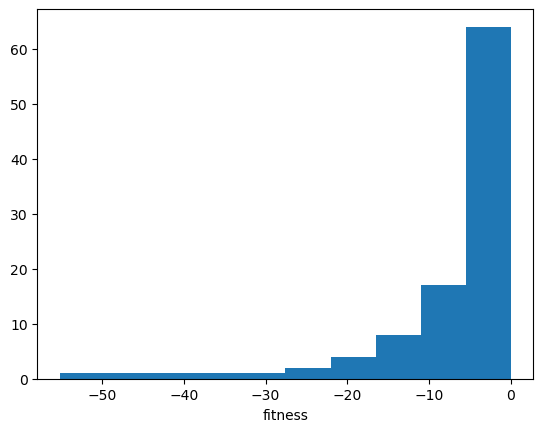

In [9]:
# Run one generation
fits = evexor.generation()
plt.hist(fits)
plt.xlabel("fitness");

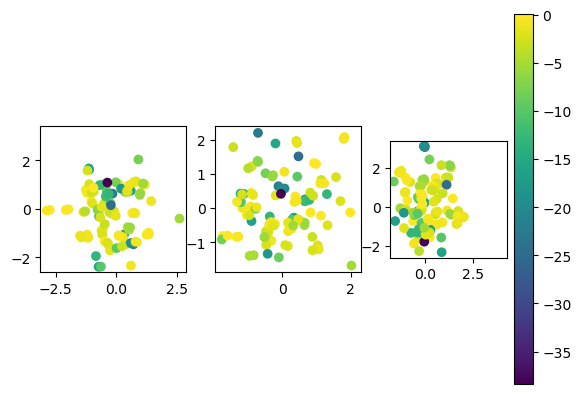

In [10]:
# Visualize weight distribution
evexor.evaluate()  # 
for i in range(3):
    plt.subplot(1,3,i+1)  # plot input weight pairs
    plt.scatter(evexor.genes[:,3*i+1], evexor.genes[:,3*i+2], c=evexor.fits);
    plt.axis('square')
plt.colorbar();

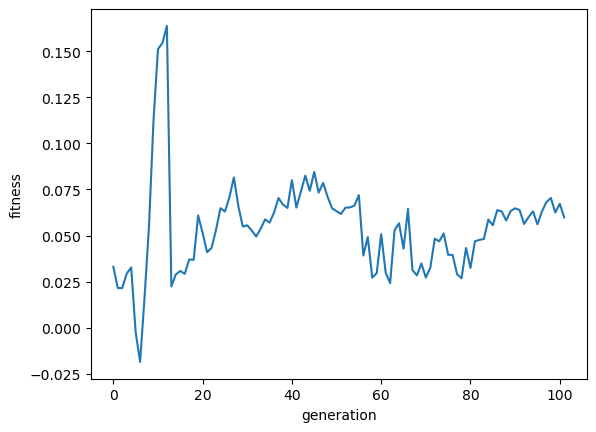

In [11]:
# Evolve generations
# You may need to run this many times, or restart if gets stuck
record = evexor.evolve(amut=0.05, pcross=0.05)
plt.plot(record)
plt.xlabel("generation"); plt.ylabel("fitness");

## Learning and evolution

Most learning algorithms have some parameters that need to be tuned.
In reinforcement learning, design of the reward function is a critical issue.
One way to design them is to apply an evolutionary algorithm.

Elfwing et al. (2011) developed a distributed evolutionary framework for a group of robots and demonstrated that reward functions as well as reinforcement learning parameters can be optimized for the task of survival and reproduction.

>{figure-md} Fig_ElfwingRewards
 ![Elfwing11rewards](figures/Elfwing11rewards.png)
>Evolution of reward functions for finding a battery pack in the survival task (left) and for the face of another robot in the mating task (right).

>{figure-md} Fig_ElfwingParameters
![Elfwing11parameters](figures/Elfwing11parameters.png)
>Evolution of parameters for reinforcement learning: $\alpha$: learning rate; $\tau$: temperature for exploration; $\gamma$: temporal discounting; $\lambda$: eligibility trace decay.

The mechanisms for learning, such as network architectures and synaptic plasticity rules, are also products of evolution. 
Niv et al. (2002) showed in a reinforcement learning task that reward-dependent plastcity rule can be evoloved.

## Game Theory

*Game theory* is a mathematical framework for modeling the interactions among multiple agents.

In game theory, what we call *agents* in reinforcement learning is called *players*, *policy* is called *strategy*, and *reward* or *fitness* is called *pay-off*.

* player $i \in I = \{1,...,n\}$

* *pure strategy* $s \in S = \{1,...,m\}$

* *pure strategy profile* for all players ($m^n$ cases):

$$ \b{s} = (s_1,...,s_n) $$

* *payoff* for player $i$:

$$ \pi_i(\b{s}) = \pi_i(s_1,...,s_n) $$

* payoff function for all players:

$$ \pi(\b{s}) = (\pi_1(\b{s}),...,\pi_n(\b{s})) $$

### Example: Prisoner’s dilemma

Two prisoners are under interrogation.
They can *cooperate* by remaining silent to be discharged with no punishment.
If both *defect* and tell the truth, they are each given a small punshment.
If only one of them defects for plea bargaining, he/she is given a small reward while the other who tries to cooperate by remaining silent is given a big punishment.

|you get/buddy gets | buddy cooperates | buddy defects |
|-------------:|:---------:|:-------:|
| you cooperate |  0 / 0  | -4/1 |
| you defect | 1 / -4 | -1 / -1 |

What is the best thing to do in this case?
Is cooperation a viable strategy?

### Mixted strategy

A player's strategy can be stochastic. That is called *mixed strategy* in game theory.

* *mixed strategy* : probability of pure strategies 

$$\b{x} = (x_{1},...,x_{m}) $$

* *mixed strategy profile* for all players: 

$$X = \mat{\b{x}_1 \\ \vdots \\ \b{x}_n} 
   = \mat{x_{11} & \cdots & x_{1m}\\
    \vdots & & \vdots\\
    x_{n1} & \cdots & x_{nm}}$$


* probability of a pure strategy profile $\b{s}$:

$$ x(\b{s}) = p(s_1,...,s_n|X) = x_{1,s_1}\cdots x_{n,s_n} $$

* payoff for player $i$ under mixed strategy prifile $X$: 

$$ u_i(X) = \sum_\b{s} x(\b{s}) \pi_i(\b{s})
   = \sum_\b{s} x_{1,s_1}\cdots x_{n,s_n} \pi_i(s_1,...,s_n) $$

* combined payoff function

$$ \b{u}(X) = (u_1(X),...,u_n(X)) $$

## Two-Player Game

Pay-off matrix for *row player*

$$ A: a_{s_1,s_2}=\pi_1(s_1,s_2) $$

Pay-off matrix for *column player*

$$ B: b_{s_1,s_2}=\pi_2(s_1,s_2) $$


### Examples

* Prisoner’s dilemma: $S=\{cooperate, defect\}$

$$ A = \mat{0 & -4 \\ 1 & -1}, \  B = \mat{0 & 1 \\ -4 & -1} $$

* Matching pennies:  $S=\{head, tail\}$

$$ A = \mat{1 & -1 \\ -1 & 1}, \  B = \mat{-1 & 1 \\ 1 & -1} $$

## Nash Equilibrium

If a player knows other players' strategies, what would he/she do to maximize own payoff?

*Best reply* for player $i$ is a mixed strategy $\b{x}_i$ that maximizes the payoff given a mixed strategy profile of all players $X=\mat{\b{x}_1 \\ \vdots \\ \b{x}_n}$.

*Nash equilibrium* is defined as a mixed strategy profile $X$ that is a best reply to itself.

In other words, any strategy other than $\b{x}_i$ does not give a higher payoff to player $i$ while others keep their strategies $\b{x}_j (j\neq i)$.

### Examples

* Prisoner’s dilemma: $S=\{cooperate, defect\}$

$$ A = \mat{0 & -4 \\ 1 & -1}, \  B = \mat{0 & 1 \\ -4 & -1} $$

both defect $ \b{x}_1 = \b{x}_2 = (0,1) $


* Matching pennies: $S=\{head, tail\}$

$$ A = \mat{1 & -1 \\ -1 & 1}, \  B = \mat{-1 & 1 \\ 1 & -1} $$

stochastic $ \b{x}_1 = \b{x}_2 = (\frac{1}{2},\frac{1}{2}) $


* Coordination game: $S=\{left, right\}$

$$ A = \mat{2 & 0 \\ 0 & 1}, \  B = A $$

both go left: $ \b{x}_1 = \b{x}_2 = (1,0) $

both go right: $ \b{x}_1 = \b{x}_2 = (0,1) $

stochastic: $ \b{x}_1 = \b{x}_2 = (\frac{2}{3},\frac{1}{3}) $

* Hawk-Dove game:  $S=\{fight, yield\}$
    * $v$: value of winning
    * $c$: cost of fighting

$$ A = \mat{\frac{v-c}{2} & v \\ 0 & \frac{v}{2}}, \  B = A^T $$

For examples, $v=2$ and $c=6$:

$$ A = \mat{-2 & 2 \\ 0 & 1}, \ B = \mat{-2 & 0 \\ 2 & 1} $$

player 1 is hawk, player 2 is dove: $ \b{x}_1 = (1,0), \b{x}_2 = (0,1) $

player 1 is dove, player 2 is hawk: $ \b{x}_1 = (0,1), \b{x}_2 = (1,0) $

sometimes hawk, sometimes dove: $ \b{x}_1 = \b{x}_2 = (\frac{1}{3},\frac{2}{3}) $

In [12]:
class Game:
    """Visualization and simulation for game theory"""

    def __init__(self, paymat):
        """Setup a game with payoff matrices"""
        self.paymat = paymat  # list of payoff matrices
        self.N = len(paymat)  # number of players
    
    def payoff(self, X):
        """Payoffs for a mixed strategy profile X"""
        pay0 = X[0]@self.paymat[0]@X[1]
        pay1 = X[0]@self.paymat[1]@X[1]
        return [pay0, pay1]
        
    def best_reply(self, X):
        """Best pure strategies for a mixed strategy profile X"""
        pay0 = self.paymat[0]@X[1]  # payoffs for pure strategies
        pay1 = X[0]@self.paymat[1]
        return [np.argmax(pay0), np.argmax(pay1)]
        # this misses mixed strategies of two best pure strategies
      
    def plot_payoff(self):
        """visualize payoff for mixed strategies for a two-player game"""
        # xg, yg = np.mgrid[0:1.01:0.05, 0:1.01:0.05]
        p = np.linspace(0., 1., 21) # prob of taking a strategy
        x = np.array([1-p, p])   # mixed strategies from [1,0] to [0,1]
        # Payoff surfaces
        pay0 = x.T@self.paymat[0]@x 
        pay1 = x.T@self.paymat[1]@x 
        # best reply lines
        best_reps = np.zeros((len(p), 2))
        for j, xj in enumerate(x.T):
            best_reps[j] = self.best_reply([xj, xj])
        #print(best_reps)
        plt.subplot(1,2,1)
        plt.imshow(pay0, extent=(0,1, 1,0))
        plt.plot(p, best_reps[:,0], c="r", lw=4)  # best replies for player 0
        plt.title("P1 payoff"); plt.ylabel("P1 strategy");  plt.xlabel("P2 strategy");
        plt.subplot(1,2,2)
        plt.imshow(pay1, extent=(0,1, 1,0))
        plt.plot(best_reps[:,1], p, c="r", lw=4)  # best replies for player 1
        plt.title("P2 payoff"); plt.xlabel("P2 strategy");

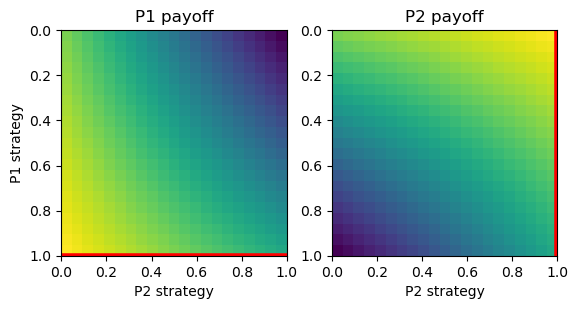

In [13]:
# Prisoner's dilemma
A = np.array([[0,-4], [1,-1]])
pd = Game([A, A.T])
pd.plot_payoff()

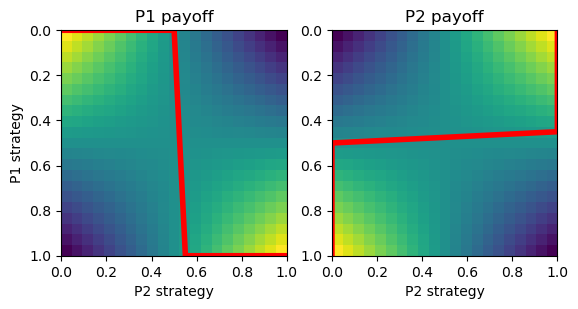

In [14]:
# Matching pennies
A = np.array([[1,-1], [-1,1]])
B = np.array([[-1,1], [1,-1]])
mp = Game([A, B])
mp.plot_payoff()

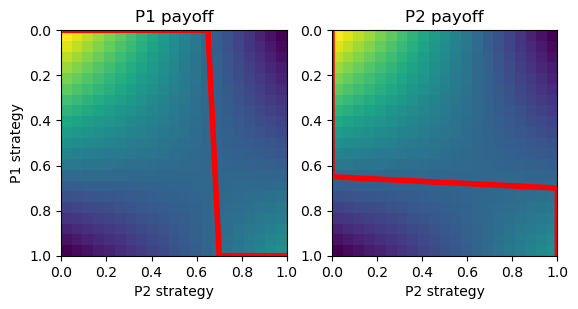

In [15]:
# Coordination game
A = np.array([[2,0], [0,1]])
cg = Game([A, A])
cg.plot_payoff()

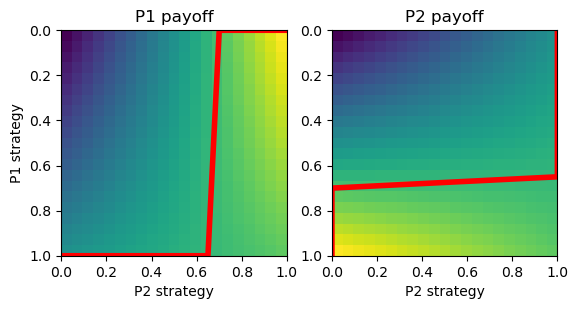

In [16]:
# Hawk-Dove game
A = np.array([[-2,2], [0,1]])
hd = Game([A, A.T])
hd.plot_payoff()

## Symmetric two-player games

If the same rule applies to both players:

$$ \pi_2(s_1,s_2) = \pi_1(s_2,s_1) $$

or

$$ B = A^T $$

it is called a *symmetric game*.  
In the above examples, the three except matching pennies are symmetric games.

If two players share the same payoff in a symmetric game:

$$ A = B = A^T $$

it is called a *partnership game* or *doubly symmetric game*.  
In the above examples, coordination game is such an example.

### Normal form of symmetric two-player games

The best reply does not change if the same amount is added/subtracted from each column of the payoff matrix of a row player.

Thus any symmetric two-player game

$$ A = \mat{a_{11} & a_{12} \\ a_{21} & a_{22}}, \  B = A^T $$

can be converted into a normal form

$$ A' = \mat{a_1 & 0 \\ 0 & a_2} $$

by shifting the payoffs as

$$ a_1 = a_{11}-a_{21}, \  a_2 = a_{22}-a_{12}. $$

Then we can classify all symmetric two-player games into three categories.

#### Category I: $a_1<0$, $a_2>0$ or $a_1>0$, $a_2<0$

e.g. Prisoner's dilemma:

$$ A = \mat{0 & -4 \\ 1 & -1} \rightarrow A' = \mat{-1 & 0 \\ 0 & 3} $$ 

* One symmetric Nash equilibrium:
    * $ \b{x}_1 = \b{x}_2 = (1,0) $ for $a_1>0$
    * $ \b{x}_1 = \b{x}_2 = (0,1) $ for $a_2>0$

#### Category II: $a_1>0$, $a_2>0$

e.g. Coordination game:

$$ A = \mat{2 & 0 \\ 0 & 1} $$

* Three symmetric Nash equilibria
    * $ \b{x}_1 = \b{x}_2 = (1,0) $
    * $ \b{x}_1 = \b{x}_2 = (0,1) $
    * $ \b{x}_1 = \b{x}_2 = (\frac{a_1}{a_1+a_2},\frac{a_2}{a_1+a_2}) $

#### Category III: $a_1<0$, $a_2<0$

e.g. Hawk-Dove game:

$$A = \mat{-2 & 2 \\ 0 & 1}
  \rightarrow A' =  \mat{-2 & 0 \\ 0 & -1} $$

* Two asymmetric and one symmetric Nash equilibria
    * $ \b{x}_1 = (1,0), \b{x}_2 = (0,1) $
    * $ \b{x}_1 = (0,1), \b{x}_2 = (1,0) $
    * $ \b{x}_1 = \b{x}_2 = (\frac{a_2}{a_1+a_2},\frac{a_1}{a_1+a_2}) $


## Evolutionary game theory

The Nash equilibrium in the game theory is an important tool for assessing what strategies a rational (selfish) player would take.
However, some Nash equilibria like the mixed strategy in the Coordination game (sometimes left, sometimes right) does not look like a good strategy.

*Evolutionary Game Theory* considers what strategy is stable against introduction of mutants.

## Evolutionarily stable strategy (ESS)

Here we consider a large population of players. 
Pairs are randomly drawn and play a symmetric two-player game

$$ B = A^T $$

When most players take a mixed strategy $\b{x}$, 
can a small mutant population taking another strategy $\b{y}$ outperform others?

When a strategy $\b{x}$ outperforms any mutant starategy $\b{x}$,
it is called an *Evolutionarily stable strategy (ESS)*.

We denote the payoff for a strategy $\b{x}$ against $\b{y}$ as 

$$ u(\b{x},\b{y}) = \b{x} A \b{y}^T $$

With a proportion of mutants $0<\epsilon<<1$, the average population strategy is

$$ \b{w} = \epsilon\b{y} + (1-\epsilon)\b{x} $$

ESS is a strategy $\b{x}$ that satisfy

$$ u(\b{x},\b{w})>u(\b{y},\b{w}) $$
for any other strategy $\b{y}$. 

ESS can be the first order:

$$ u(\b{x},\b{x})>u(\b{y},\b{x}) $$
performing better with incumbents, 
or the second order:

$$ u(\b{x},\b{x})=u(\b{y},\b{x}) \mbox{ and } u(\b{x},\b{y})>u(\b{y},\b{y}) $$
performing equally with incumbents but better with mutants than themselves.

ESS does not require

$$ u(\b{x},\b{x}) > u(\b{y},\b{y}), $$
meaning that in another population where $\b{y}$ is a majority, $\b{y}$ can outperform $\b{x}$ and be another ESS.

ESS is the best reply to itself, so that $(\b{x},\b{x})$ is a Nash equilibrium, but not all Nash equilibria are ESS, as we see below.

### EES in symmetric two-player games

Based on the categorization by the normal forms, let us see which Nash equilibrium is ESS.

#### Category I: $a_1<0$, $a_2>0$ or $a_1>0$, $a_2<0$

e.g. Prisoner's dilemma:

$$ A = \mat{0 & -4 \\ 1 & -1} \rightarrow A' = \mat{-1 & 0 \\ 0 & 3} $$ 

* One symmetric Nash equilibrium, which is ESS.
    * $ \b{x}_1 = \b{x}_2 = (1,0) $ for $a_1>0$  
    * $ \b{x}_1 = \b{x}_2 = (0,1) $ for $a_2>0$

#### Category II: $a_1>0$, $a_2>0$

e.g. Coordination game:

$$ A = \mat{2 & 0 \\ 0 & 1} $$

* Three symmetric Nash equilibria:
    * $ \b{x}_1 = \b{x}_2 = (1,0) $: ESS
    * $ \b{x}_1 = \b{x}_2 = (0,1) $: ESS
    * $ \b{x}_1 = \b{x}_2 = (\frac{a_1}{a_1+a_2},\frac{a_2}{a_1+a_2}) $: not ESS

#### Category III: $a_1<0$, $a_2<0$

e.g. Hawk-Dove game:

$$A = \mat{-2 & 2 \\ 0 & 1}
  \rightarrow A' =  \mat{-2 & 0 \\ 0 & -1} $$

* Two asymmetric and one symmetric Nash equilibria: 
    * $ \b{x}_1 = (1,0), \b{x}_2 = (0,1) $: not ESS
    * $ \b{x}_1 = (0,1), \b{x}_2 = (1,0) $: not ESS
    * $ \b{x}_1 = \b{x}_2 = (\frac{a_2}{a_1+a_2},\frac{a_1}{a_1+a_2}) $: ESS

## Replicator Dynamics

In addition to analyzing the stablilty of a given strategy, evolutionary game theory allows us to predict how strategies would evolve in time.

For simplicity we assume that each subpopulation takes one of $K$ pure strategies.
* $p_i(t)$: number of players with strategy $i\in K$
* total population: $p(t)=\sum_{i=1}^K p_i(t)$
* population share: $x_i(t)=\frac{p_i(t)}{p(t)}$
* population state: 

$$ x(t) = (x_1(t),...,x_K(t)) $$

If the reproduction rate is given by the payoff and fitness, the death rate is given by $d$, the growth of sub-population is given by

$$
    \frac{dp_i(t)}{dt} = (\b{e}_i A\b{x}(t)^T–d)p_i(t)
$$
where $\b{e}_i=(0,...,1,...,0)$ with $1$ in $i$-th component.

Then the dynamics of the population share is given by

$$
    \frac{dx_i(t)}{dt} = \frac{d}{dt} \frac{p_i(t)}{p(t)}
    = \frac{1}{p(t)}\frac{dp_i(t)}{dt} - \frac{p_i(t)}{p(t)^2}\frac{dp(t)}{dt}
$$

$$
    = (\b{e}_i A\b{x}(t)^T–d)x_i(t) - x_i(t)\sum_{j=1}^K(\b{e}_j A\b{x}(t)^T–d)x_j(t)
$$

$$
    = \b{e}_i A\b{x}(t)^T x_i(t) –\b{x}(t)A\b{x}(t)^T x_i(t) 
$$
which leads us to the *replicator equation*.

$$
    \frac{dx_i(t)}{dt} = (\b{e}_i–\b{x}(t))A\b{x}(t)^T x_i(t)
$$

In [17]:
from scipy.integrate import odeint

class RepGame(Game):
    """Replicator dynamics"""
    
    def repeq(self, x, t=0):
        """replicator equation for odeint"""
        dx = np.ravel(self.paymat[0]@x - x@self.paymat[0]@x)*x
        return dx
    
    def replicator(self, x0, tt):
        """Replicator dynamimcs
        x0: initial population, tt: array of time points"""
        xt = odeint(self.repeq, x0, tt)
        return xt

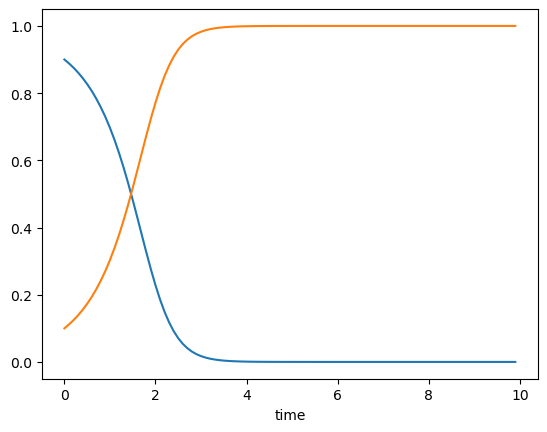

In [18]:
# Prisonner's dilemma
A = np.matrix([[0,-4], [1,-1]])  # payoff matrix
pd = RepGame([A, A.T])
tt = np.arange(0, 10, 0.1)
xt = pd.replicator(np.array([0.9, 0.1]), tt)
plt.plot(tt, xt)
plt.xlabel("time");

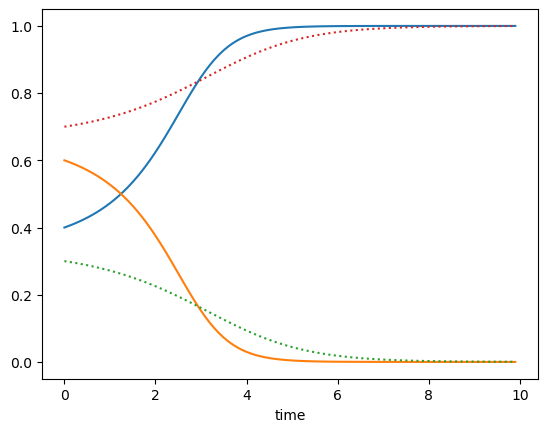

In [19]:
# Coordination game
A = np.array([[2,0], [0,1]])
cg = RepGame([A, A])
tt = np.arange(0, 10, 0.1)
xt = cg.replicator(np.array([0.4, 0.6]), tt)
plt.plot(tt, xt)
xt = cg.replicator(np.array([0.3, 0.7]), tt)
plt.plot(tt, xt, ':')
plt.xlabel("time");

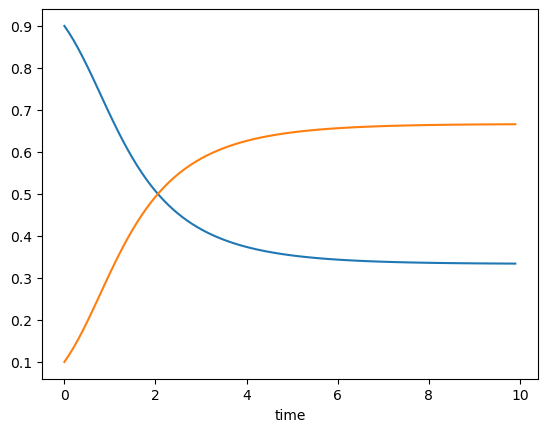

In [20]:
# Hawk-Dove game
A = np.array([[-2,2], [0,1]])
hd = RepGame([A, A.T])
tt = np.arange(0, 10, 0.1)
xt = hd.replicator(np.array([0.9, 0.1]), tt)
plt.plot(tt, xt)
plt.xlabel("time");

## Rock-scissors-paper game
Now consider a symmetric two-player game with three pure strategies

$$ A = \mat{0 & 1+a & -1 \\ -1 & 0 & 1+a \\ 1+a & -1 & 0} $$

The parameter $a$ controls the importance of winning versus not losing.

There is a Nash equilibrium at $\b{x}=(\frac{1}{3},\frac{1}{3},\frac{1}{3})$. The replicator dynamics is known to show oscillatory behaviors around the equilibrium depending on the parameter $a$.

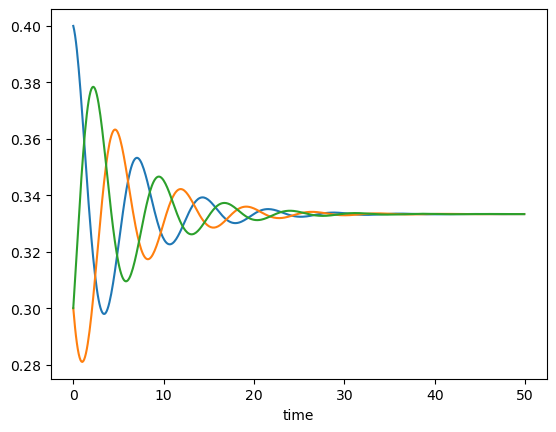

In [21]:
# Rock-scissors-paper game
a = 1  # also try a = 1, a= -0.5
A = np.array([[0, 1+a, -1], [-1, 0, 1+a], [1+a, -1, 0]])
rsp = RepGame([A, A.T])
tt = np.arange(0, 50, 0.1)
xt = rsp.replicator(np.array([0.4, 0.3, 0.3]), tt)
plt.plot(tt, xt)
plt.xlabel("time");

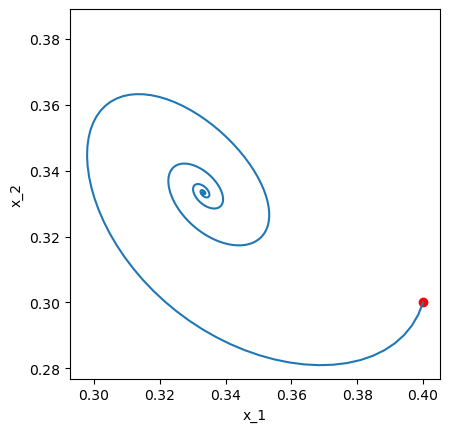

In [22]:
plt.plot(xt[0,0], xt[0,1], "ro")  # initial point
plt.plot(xt[:,0], xt[:,1])
plt.xlabel("x_1"); plt.ylabel("x_2"); plt.axis("square");

## Learning by multiple agents

In the evolutionary game theory, each player is assumed to have a fixed strategy for its liftime.
What if players can change their strategies during their lifetime depending on their experiences.

Reinforcement learning of *multiple agents* is an active field of research.
For each agent, other agents can be considered as a part of the environment, but because the policies of other agents change by learning, it is not a stationary Markov decision process.
We can simply apply standard reinforcement learning like Q-learning, but in that case convergence is not theoretically guaranteed.
In learning the rock-scissors-paper game, appearance of chaotic dynamics has been reported (Sato et al. 2002).

Another possible approach is to learn a model of the behaviors of other agents, or even a model of how other agents change their behavior by learning, and then apply model-based approach to find appropriate actions (Suzuki et al. 2012).

## Game theory in neuroscience 

Game theoretic settings have been used extensively in cognitive neuroscience research to assess the brain's mechanisms for cooperative or selfish behaviors.

* Prisoner’s Dilemma
    * Activation of reward circuit for cooperation (Rilling et al., 2002)
    * Reduced serotonin reduces cooperation (Wood et al., 2006)


* Ultimatum Game (Sanfey et al., 2003)  
Proposer: split money for self and other  
Responder: accept or reject

## Theory of mind

The capacity for estimating and predicting other's mental state is called *theory of mind*.
Human children acquire such capability during the course of development, but it has been suggested that that capacity is impaired in autistic children.

There are computational models about how model-bases reinforcement learning agents can perform cooperative behaviors (Yoshida et al. 2008).
There are also brain imaging experiments to assess what brain circuits are involved in predicting other's behaviors (Yoshida et al. 2010; Suzuki et al. 2014).

## Exercise

1) Try evolutionary algorithm for an optimization of your interest while varying the methods and parameters for mutaion, crossover, and selection.

2) Model some kind of interaction between people in a game theoretic framework, define payoff matrices, and identify Nash equilibria and ESSs.

3) See how the replicator dynamics of the rock-scissors-paper game changes with the parameter $a$.

## References

* Evolutionary algorithms
    * Yu X, Gen M (2012) Introduction to Evolutionary Algorithms. Springer.
    * Reisinger J, Miikkulainen R (2007) Acquiring Evolvability through Adaptive Representations. GECCO 2007.
    * Elfwing S, Uchibe E, Doya K, Christensen HI (2011) Darwinian embodied evolution of the learning ability for survival. Adaptive Behavior 19:101-120.
    * Niv Y, Joel D, Meilijson I, Ruppin E (2002) Evolution of reinforcement learning in uncertain environments: a simple explanation for complex foraging behaviors. Adaptive Behavior.


* Game theory
    * Weibull J (1995) Evolutionary Game Theory. MIT Press.
    * Rilling JK, Gutman DA, Zeh TR, Pagnoni G, Berns GS, Kilts CD (2002) A neural basis for social cooperation. Neuron 35:395-405.
    * Sanfey AG, Rilling JK, Aronson JA, Nystrom LE, Cohen JD (2003) The neural basis of economic decision-making in the Ultimatum Game. Science 300:1755-1758.
    * Barraclough DJ, Conroy ML, Lee D (2004) Prefrontal cortex and decision making in a mixed-strategy game. Nature neuroscience 7:404-410.
    
    
* Multi-agent RL
    * Sato Y, Akiyama E, Farmer JD (2002) Chaos in learning a simple two-person game. Proceedings of the National Academy of Sciences, USA, 99:4748-4751.
    * Jaderberg M, Czarnecki WM, Dunning I, Marris L, Lever G, Castaneda AG, Beattie C, Rabinowitz NC, Morcos AS, Ruderman A, Sonnerat N, Green T, Deason L, Leibo JZ, Silver D, Hassabis D, Kavukcuoglu K, Graepel T (2019). Human-level performance in 3D multiplayer games with population-based reinforcement learning. Science, 364, 859-865. https://doi.org/10.1126/science.aau6249
    
    
* Theory of mind
    * Yoshida W, Dolan RJ, Friston KJ (2008) Game theory of mind. PLoS Computational Biology 4:e1000254.
    * Yoshida W, Seymour B, Friston KJ, Dolan RJ (2010) Neural mechanisms of belief inference during cooperative games. The Journal of Neuroscience, 30:10744-10751.
    * Suzuki S, Harasawa N, Ueno K, Gardner JL, Ichinohe N, Haruno M, Cheng K, Nakahara H (2012) Learning to simulate others' decisions. Neuron, 74:1125-1137.







## Author to do list
* Evolutionar robotics examples, e.g., Nolfi and Floreano
* Game learning issues and examples